In [21]:
import string
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torchvision.models import (
    mobilenet_v2, MobileNet_V2_Weights,
    resnet18, ResNet18_Weights
)

In [6]:
def decompress_npz(npz_file):
    # Load the compressed dataset
    data = np.load(npz_file)
    images = data['images']
    labels = data['labels']

    return images, labels

In [8]:
class LabelMapper:
    # Create a label list containing uppercase letters (A-Z)
    labels = list(string.ascii_uppercase)

    # Create a label-to-index map
    label_to_index_map = {label: idx for idx, label in enumerate(labels)}

    # Create an index-to-label map
    index_to_label_map = {idx: label for idx, label in enumerate(labels)}

    @staticmethod
    def label_to_index(label):
        """
        Convert a label to its corresponding index.
        Args:
            label: The label to convert.
        Returns:
            The index corresponding to the label, or None if the label is not found.
        """
        return LabelMapper.label_to_index_map.get(label, None)

    @staticmethod
    def index_to_label(index):
        """
        Convert an index to its corresponding label.
        Args:
            index: The index to convert.
        Returns:
            The label corresponding to the index, or None if the index is not found.
        """
        return LabelMapper.index_to_label_map.get(index, None)

In [9]:
class ASLDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Initializes the dataset with images and labels.

        Args:
            images (list or array): The dataset of images.
            labels (list): Corresponding labels for each image ('0-9' and 'A-Z').
            transform (callable, optional): Transform to apply to images.
        """
        self.images = images  # List/array of images
        self.labels = labels  # Corresponding labels
        self.transform = transform

        # Convert labels to numerical format
        self.numerical_labels = np.array([LabelMapper.label_to_index(label) for label in labels])

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.labels)

    def __getitem__(self, idx):
        """
        Retrieves an image and its corresponding label.

        Args:
            idx (int): Index of the sample.

        Returns:
            tuple: (image, label) where image is a PIL Image and label is a tensor.
        """
        image = self.images[idx]  # Get image at index
        label = self.numerical_labels[idx]  # Get corresponding label

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)  # Convert label to tensor

        return image, label

In [10]:
class CustomMobileNetV2(nn.Module):
    def __init__(self, num_classes):
        super(CustomMobileNetV2, self).__init__()
        # Load the pre-trained MobileNetV2 model
        self.base_model = mobilenet_v2(weights=MobileNet_V2_Weights.DEFAULT)

        # Change the classifier to output 1280 features instead of num_classes
        self.base_model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.base_model.last_channel, 1280),  # Change output size to 1280
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1280, num_classes)  # Output layer for classification
        )

    def forward(self, x):
        return self.base_model(x)


class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        # Load the pre-trained ResNet50 model
        self.base_model = resnet18(weights=ResNet18_Weights.DEFAULT)

        # Modify the fully connected layer (classifier part) of ResNet18
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 1280),  # Change output size to 1280
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1280, num_classes)  # Final output layer for classification
        )

    def forward(self, x):
        return self.base_model(x)

In [16]:
# Total classes of uppercase letters (A-Z)
total_classes = len(string.ascii_uppercase)
model = CustomMobileNetV2(total_classes)

# Move the models to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print("MobileNetV2 Summary:")
summary(model, (3, 224, 224))

MobileNetV2 Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-

In [17]:
def plot_performance_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plots the training and validation loss and accuracy over epochs with different colors."""
    plt.figure(figsize=(12, 5))

    # Loss subplot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss', color='blue', linestyle='-')
    plt.plot(val_losses, label='Validation Loss', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()

    # Accuracy subplot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue', linestyle='-')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


def print_confusion_matrix(y_true, y_pred, report=True):
    # Get sorted unique labels
    labels = sorted(list(set(y_true)))

    # Create confusion matrix
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)

    # Convert to DataFrame for better readability
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)

    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(10, 7))
    sns.heatmap(df_cmx, annot=True, fmt='g', cmap='Blues', square=False)

    # Ensure y-axis is displayed correctly
    ax.set_ylim(len(labels), 0)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Optional: print classification report
    if report:
        print('Classification Report')
        print(classification_report(y_true, y_pred))


In [28]:
def run_epoch(model, dataloader, loss_fn, optimizer, device, train=True):
    """Runs a single epoch for training or validation and returns the average loss and accuracy."""
    if train:
        model.train()  # Set model to training mode
    else:
        model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.set_grad_enabled(train):  # Enable gradients only if training
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients only if training
            if train:
                optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()

            # Backward pass and optimization only if training
            if train:
                loss.backward()
                optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.eq(preds, labels).float().sum()
            total_preds += labels.size(0)

    avg_loss = running_loss / len(dataloader)
    avg_accuracy = (correct_preds / total_preds).item()

    return avg_loss, avg_accuracy


def train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device):
    print("Training Started.")

    # Lists to store loss and accuracy for each epoch
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    # Training loop
    for epoch in range(num_epochs):
        # Clear any cached GPU memory
        torch.cuda.empty_cache()

        # Run training and validation phases
        train_loss, train_accuracy = run_epoch(model, train_loader, loss_fn, optimizer, device, train=True)
        val_loss, val_accuracy = run_epoch(model, val_loader, loss_fn, optimizer, device, train=False)

        # Store metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch metrics
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%")

    print("Training finished.")

    # Plot training and validation loss and accuracy
    plot_performance_history(train_losses, val_losses, train_accuracies, val_accuracies)

In [23]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Evaluate the model
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation during evaluation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass (get predictions)
            outputs = model(images)

            # Get the predicted class (index of the max logit)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())  # Append predictions
            all_labels.extend(labels.cpu().numpy())  # Append true labels

    # Convert indexes to real class labels
    all_preds_labels = [LabelMapper.index_to_label(pred) for pred in all_preds]
    all_labels_labels = [LabelMapper.index_to_label(label) for label in all_labels]

    # Calculate accuracy
    accuracy = accuracy_score(all_labels_labels, all_preds_labels)
    print(f'Accuracy of the model on the test set: {accuracy * 100:.2f}%')

    # Confusion Matrix
    print_confusion_matrix(all_labels_labels, all_preds_labels)

In [25]:
def train_evaluate(npz_file):
    # Load the .npz dataset
    images, labels = decompress_npz(npz_file)

    # Split the images and labels into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resize images
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Set up hyperparameters
    num_classes = len(np.unique(labels))
    num_epochs = 10
    batch_size = 100
    learning_rate = 0.001

    train_dataset = ASLDataset(X_train, y_train, transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = ASLDataset(X_test, y_test, transform=transform)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model
    model = CustomMobileNetV2(num_classes=num_classes)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, device)

    evaluate_model(model, val_loader, device)

Training Started.
Epoch [1/10], Train Loss: 0.2911, Train Accuracy: 91.66%, Val Loss: 0.1671, Val Accuracy: 95.22%
Epoch [2/10], Train Loss: 0.1278, Train Accuracy: 96.40%, Val Loss: 0.1141, Val Accuracy: 96.79%
Epoch [3/10], Train Loss: 0.1064, Train Accuracy: 97.04%, Val Loss: 0.1077, Val Accuracy: 96.94%
Epoch [4/10], Train Loss: 0.0905, Train Accuracy: 97.46%, Val Loss: 0.0956, Val Accuracy: 97.35%
Epoch [5/10], Train Loss: 0.0757, Train Accuracy: 97.89%, Val Loss: 0.1195, Val Accuracy: 96.69%
Epoch [6/10], Train Loss: 0.0695, Train Accuracy: 98.05%, Val Loss: 0.0928, Val Accuracy: 97.61%
Epoch [7/10], Train Loss: 0.0616, Train Accuracy: 98.29%, Val Loss: 0.0866, Val Accuracy: 97.83%
Epoch [8/10], Train Loss: 0.0571, Train Accuracy: 98.33%, Val Loss: 0.0892, Val Accuracy: 97.79%
Epoch [9/10], Train Loss: 0.0518, Train Accuracy: 98.54%, Val Loss: 0.1517, Val Accuracy: 96.14%
Epoch [10/10], Train Loss: 0.0475, Train Accuracy: 98.66%, Val Loss: 0.2310, Val Accuracy: 94.28%
Training fi

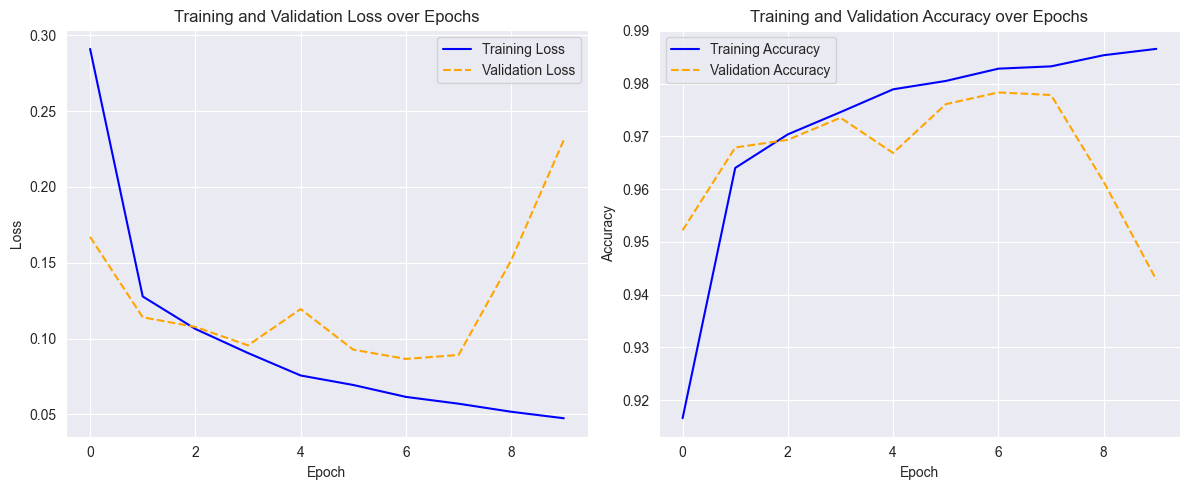

Accuracy of the model on the test set: 94.28%


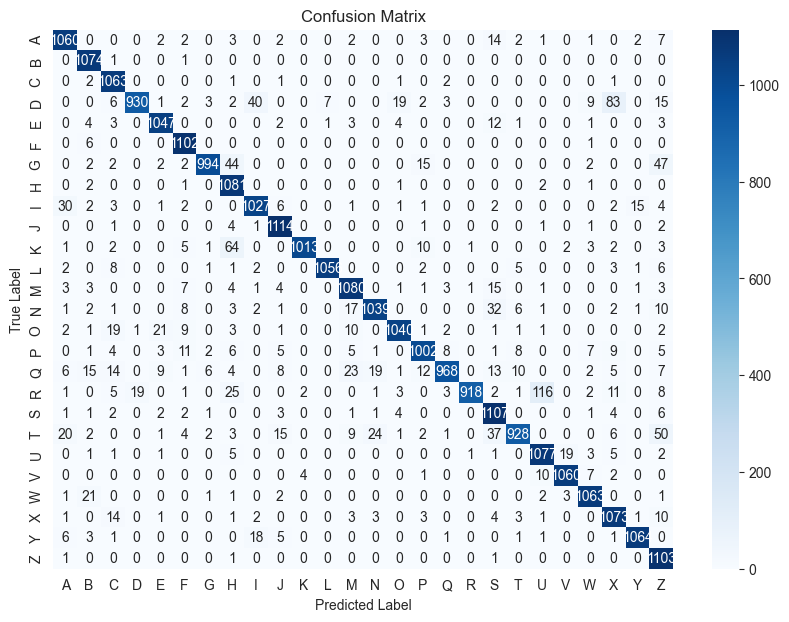

Classification Report
              precision    recall  f1-score   support

           A       0.93      0.96      0.95      1101
           B       0.94      1.00      0.97      1076
           C       0.92      0.99      0.96      1071
           D       0.98      0.83      0.90      1122
           E       0.96      0.97      0.96      1081
           F       0.95      0.99      0.97      1109
           G       0.98      0.90      0.94      1110
           H       0.86      0.99      0.92      1088
           I       0.94      0.94      0.94      1097
           J       0.95      0.99      0.97      1125
           K       0.99      0.92      0.95      1107
           L       0.99      0.97      0.98      1087
           M       0.94      0.96      0.95      1128
           N       0.95      0.92      0.94      1126
           O       0.97      0.93      0.95      1115
           P       0.95      0.93      0.94      1078
           Q       0.98      0.86      0.92      1123
     

In [30]:
train_evaluate(r'C:\Users\xbpow\Downloads\Sign-Language-Recognition\data\compressed_asl_crop_v2.npz')